# Dataset pre-processing

download raw dataset

In [ ]:
import os
import requests
from tqdm import tqdm
import zipfile
import pathlib

# install aria2
!apt-get -y install aria2

DATA_ROOT = "/content/data"
OUT_DIR = f"{DATA_ROOT}/plantseg"
zip_path = f"{OUT_DIR}/plantsegv3.zip"
os.makedirs(OUT_DIR, exist_ok=True)

url = "https://zenodo.org/records/14935094/files/plantsegv3.zip?download=1"

!aria2c -x 16 -s 16 -k 1M -o plantsegv3.zip -d "$OUT_DIR" "$url"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libaria2-0 libc-ares2
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2
0 upgraded, 3 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,513 kB of archives.
After this operation, 5,441 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-ares2 amd64 1.18.1-1ubuntu0.22.04.3 [45.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libaria2-0 amd64 1.36.0-1 [1,086 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aria2 amd64 1.36.0-1 [381 kB]
Fetched 1,513 kB in 1s (1,172 kB/s)
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
Unpacking libc-ares2:amd64 (1.18.1-1ubun

In [ ]:
import os
import requests
from tqdm import tqdm
import zipfile
import pathlib

DATA_ROOT = "/content/data"
OUT_DIR = f"{DATA_ROOT}/plantseg"
os.makedirs(OUT_DIR, exist_ok=True)

zip_path = f"{OUT_DIR}/plantsegv3.zip"


extract_dir = f"{OUT_DIR}/plantsegv3"
os.makedirs(extract_dir, exist_ok=True)

def unzip_with_progress(zip_path, extract_to):
    if len(os.listdir(extract_to)) > 0:
        print("Already extracted:", extract_to)
        return

    print("Extracting zip with progress...")

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        files = zip_ref.namelist()
        progress = tqdm(total=len(files), desc="Unzipping", unit="files")

        for file in files:
            zip_ref.extract(file, extract_to)
            progress.update(1)

        progress.close()
    print("Unzipped to:", extract_to)


unzip_with_progress(zip_path, extract_dir)

# ===============================
# 3. Show extracted top-level files
# ===============================
print("Top-level files/dirs:")
print("\n".join([str(p) for p in pathlib.Path(extract_dir).iterdir()][:50]))


Extracting zip with progress...


Unzipping: 100%|██████████| 22929/22929 [00:11<00:00, 2070.28files/s]

Unzipped to: /content/data/plantseg/plantsegv3
Top-level files/dirs:
/content/data/plantseg/plantsegv3/plantsegv3


In [3]:
import os
import numpy as np
import cv2

MASK_DIR = "/content/data/plantseg/plantsegv3/plantsegv3/annotations/train"


# Training

In [ ]:
# ============================================
# 0. Imports & Global Config
# ============================================
import os
import glob
from typing import Tuple, Optional, List

import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm


%matplotlib inline


ROOT = "/content/data/plantseg/plantsegv3/plantsegv3"

TRAIN_IMG_DIR = os.path.join(ROOT, "images", "train")
TRAIN_MASK_DIR = os.path.join(ROOT, "annotations", "train")

VAL_IMG_DIR   = os.path.join(ROOT, "images", "val")
VAL_MASK_DIR  = os.path.join(ROOT, "annotations", "val")

TEST_IMG_DIR  = os.path.join(ROOT, "images", "test")
TEST_MASK_DIR = os.path.join(ROOT, "annotations", "test")

NUM_CLASSES = 116  # 0=background + 115 diseases
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", DEVICE)


Using device: cuda


In [ ]:
# ============================================
# 1. Dataset & DataLoader
# ============================================

class PlantSegDataset(Dataset):
    def __init__(self, img_dir: str, mask_dir: str,
                 resize: Optional[Tuple[int, int]] = (512, 512)):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.resize = resize

        img_paths = []
        for ext in ("*.jpg", "*.jpeg", "*.png"):
            img_paths.extend(glob.glob(os.path.join(img_dir, ext)))
        img_paths = sorted(img_paths)

        self.samples: List[Tuple[str, str]] = []
        for ip in img_paths:
            rel = os.path.relpath(ip, img_dir)  # e.g. subdir/file.jpg
            stem = os.path.splitext(rel)[0]     # subdir/file
            mask_path = os.path.join(mask_dir, stem + ".png")
            if os.path.exists(mask_path):
                self.samples.append((ip, mask_path))

        print(f"[{os.path.basename(img_dir)}] Found {len(self.samples)} paired image-mask samples.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img_bgr is None:
            raise RuntimeError(f"Failed to read image: {img_path}")
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)


        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if mask is None:
            raise RuntimeError(f"Failed to read mask: {mask_path}")


        if mask.ndim == 3:
            mask = mask[..., 0]
        mask = np.ascontiguousarray(mask)


        if self.resize is not None:
            h, w = self.resize
            img = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

        img = Image.fromarray(img)
        img = F.to_tensor(img)  # [0,1], float32
        img = F.normalize(
            img,
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )

        mask = torch.from_numpy(mask.astype(np.int64))  # [H,W], long

        return img, mask


train_dataset = PlantSegDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, resize=(512, 512))
val_dataset   = PlantSegDataset(VAL_IMG_DIR,   VAL_MASK_DIR,   resize=(512, 512))
test_dataset  = PlantSegDataset(TEST_IMG_DIR,  TEST_MASK_DIR,  resize=(512, 512))

# DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)


[train] Found 7916 paired image-mask samples.
[val] Found 1247 paired image-mask samples.
[test] Found 2295 paired image-mask samples.


In [6]:
# ============================================
# 2. Model + Optimizer
# ============================================

model = models.segmentation.deeplabv3_resnet101(
    weights=None,
    weights_backbone=models.ResNet101_Weights.IMAGENET1K_V2,
    num_classes=NUM_CLASSES,
).to(DEVICE)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Model initialized with DeepLabV3-ResNet101.")


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


100%|██████████| 171M/171M [00:00<00:00, 222MB/s]


Model initialized with DeepLabV3-ResNet101.


In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
import os

SAVE_DIR = "/content/drive/MyDrive/DeepLearning/final_project/models"
os.makedirs(SAVE_DIR, exist_ok=True)


In [12]:
# ============================================
# 3.1 Metrics: confusion matrix & mIoU
# ============================================

def update_confusion_matrix(confmat, preds, targets, num_classes):
    """
    confmat: [K,K] numpy array
    preds, targets: [B,H,W] LongTensor (on any device)
    """
    preds = preds.view(-1).cpu().numpy()
    targets = targets.view(-1).cpu().numpy()

    mask = (targets >= 0) & (targets < num_classes)
    preds = preds[mask]
    targets = targets[mask]

    k = num_classes
    indices = targets * k + preds
    bincount = np.bincount(indices, minlength=k*k)
    confmat += bincount.reshape(k, k)
    return confmat


def compute_iou_from_confmat(confmat):
    """
    confmat[c_gt, c_pred]
    IoU_c = TP_c / (TP_c + FP_c + FN_c)
    """
    tp = np.diag(confmat)
    fp = confmat.sum(axis=0) - tp
    fn = confmat.sum(axis=1) - tp
    denom = tp + fp + fn

    iou_per_class = tp / (denom + 1e-6)
    miou = iou_per_class.mean()
    return miou, iou_per_class


def compute_acc_from_confmat(confmat):
    """
    Acc_c = TP_c / (TP_c + FN_c) = diag / row_sum
    """
    tp = np.diag(confmat)
    fn = confmat.sum(axis=1) - tp
    acc_per_class = tp / (tp + fn + 1e-6)
    macc = acc_per_class.mean()
    return macc, acc_per_class


In [13]:
# ============================================
# 3.2 Train / Eval Functions
# ============================================

def train_one_epoch(model, loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0

    for imgs, masks in tqdm(loader, desc=f"Epoch {epoch} [train]"):
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)["out"]  # [B,C,H,W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    print(f"Epoch {epoch}: train loss = {epoch_loss:.4f}")
    return epoch_loss


def evaluate(model, loader, criterion, num_classes, split_name="val"):
    model.eval()
    running_loss = 0.0
    confmat = np.zeros((num_classes, num_classes), dtype=np.int64)

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc=f"[{split_name}] evaluating"):
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(imgs)["out"]
            loss = criterion(outputs, masks)

            running_loss += loss.item() * imgs.size(0)

            preds = outputs.argmax(1)  # [B,H,W]
            confmat = update_confusion_matrix(confmat, preds, masks, num_classes)

    avg_loss = running_loss / len(loader.dataset)
    miou, iou_per_class = compute_iou_from_confmat(confmat)
    macc, acc_per_class = compute_acc_from_confmat(confmat)

    print(f"{split_name} loss = {avg_loss:.4f}, {split_name} mIoU = {miou:.4f}, {split_name} mAcc = {macc:.4f}")
    return avg_loss, miou, iou_per_class, macc, acc_per_class


Epoch 1 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 1: train loss = 1.5270


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.8378, val mIoU = 0.0620, val mAcc = 0.0973
  ✅ New best val mIoU: 0.0620, model saved to best_deeplabv3_plantseg.pth


Epoch 2 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 2: train loss = 0.8241


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.6928, val mIoU = 0.1187, val mAcc = 0.1873
  ✅ New best val mIoU: 0.1187, model saved to best_deeplabv3_plantseg.pth


Epoch 3 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 3: train loss = 0.6318


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.5965, val mIoU = 0.1716, val mAcc = 0.2722
  ✅ New best val mIoU: 0.1716, model saved to best_deeplabv3_plantseg.pth


Epoch 4 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 4: train loss = 0.5002


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.5233, val mIoU = 0.2293, val mAcc = 0.3410
  ✅ New best val mIoU: 0.2293, model saved to best_deeplabv3_plantseg.pth


Epoch 5 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 5: train loss = 0.4049


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.5300, val mIoU = 0.2496, val mAcc = 0.3828
  ✅ New best val mIoU: 0.2496, model saved to best_deeplabv3_plantseg.pth


Epoch 6 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 6: train loss = 0.3378


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.4898, val mIoU = 0.2987, val mAcc = 0.4311
  ✅ New best val mIoU: 0.2987, model saved to best_deeplabv3_plantseg.pth


Epoch 7 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 7: train loss = 0.2921


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.4717, val mIoU = 0.3094, val mAcc = 0.4475
  ✅ New best val mIoU: 0.3094, model saved to best_deeplabv3_plantseg.pth


Epoch 8 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 8: train loss = 0.2463


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.4673, val mIoU = 0.3224, val mAcc = 0.4627
  ✅ New best val mIoU: 0.3224, model saved to best_deeplabv3_plantseg.pth


Epoch 9 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79f247d751c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79f247d751c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 9: train loss = 0.2135


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.4650, val mIoU = 0.3288, val mAcc = 0.4755
  ✅ New best val mIoU: 0.3288, model saved to best_deeplabv3_plantseg.pth


Epoch 10 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 10: train loss = 0.1904


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.4938, val mIoU = 0.3341, val mAcc = 0.4856
  ✅ New best val mIoU: 0.3341, model saved to best_deeplabv3_plantseg.pth


Epoch 11 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 11: train loss = 0.1769


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.4950, val mIoU = 0.3527, val mAcc = 0.4937
  ✅ New best val mIoU: 0.3527, model saved to best_deeplabv3_plantseg.pth


Epoch 12 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 12: train loss = 0.1579


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.4993, val mIoU = 0.3346, val mAcc = 0.4858


Epoch 13 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 13: train loss = 0.1496


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.4779, val mIoU = 0.3552, val mAcc = 0.4993
  ✅ New best val mIoU: 0.3552, model saved to best_deeplabv3_plantseg.pth


Epoch 14 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 14: train loss = 0.1394


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.4509, val mIoU = 0.3752, val mAcc = 0.5065
  ✅ New best val mIoU: 0.3752, model saved to best_deeplabv3_plantseg.pth


Epoch 15 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 15: train loss = 0.1244


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.4735, val mIoU = 0.3520, val mAcc = 0.4814


Epoch 16 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 16: train loss = 0.1196


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.4768, val mIoU = 0.3811, val mAcc = 0.5105
  ✅ New best val mIoU: 0.3811, model saved to best_deeplabv3_plantseg.pth


Epoch 17 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 17: train loss = 0.1254


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.4948, val mIoU = 0.3507, val mAcc = 0.4835


Epoch 18 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 18: train loss = 0.1131


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.4828, val mIoU = 0.3501, val mAcc = 0.4731


Epoch 19 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 19: train loss = 0.1090


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.5011, val mIoU = 0.3735, val mAcc = 0.5082


Epoch 20 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 20: train loss = 0.0975


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.4966, val mIoU = 0.3794, val mAcc = 0.5173


Epoch 21 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 21: train loss = 0.1005


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.5112, val mIoU = 0.3508, val mAcc = 0.4631


Epoch 22 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 22: train loss = 0.0971


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.4900, val mIoU = 0.3807, val mAcc = 0.5056


Epoch 23 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 23: train loss = 0.0890


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.5044, val mIoU = 0.3706, val mAcc = 0.5016


Epoch 24 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 24: train loss = 0.0912


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.5205, val mIoU = 0.3550, val mAcc = 0.4719


Epoch 25 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 25: train loss = 0.0980


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.5867, val mIoU = 0.3307, val mAcc = 0.4642


Epoch 26 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 26: train loss = 0.0989


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.5200, val mIoU = 0.3699, val mAcc = 0.4971


Epoch 27 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 27: train loss = 0.0757


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.5035, val mIoU = 0.3945, val mAcc = 0.5176
  ✅ New best val mIoU: 0.3945, model saved to best_deeplabv3_plantseg.pth


Epoch 28 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 28: train loss = 0.0704


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.5177, val mIoU = 0.3919, val mAcc = 0.5215


Epoch 29 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 29: train loss = 0.0997


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.5426, val mIoU = 0.3619, val mAcc = 0.4958


Epoch 30 [train]:   0%|          | 0/990 [00:00<?, ?it/s]

Epoch 30: train loss = 0.0805


[val] evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

val loss = 0.5182, val mIoU = 0.3892, val mAcc = 0.5276


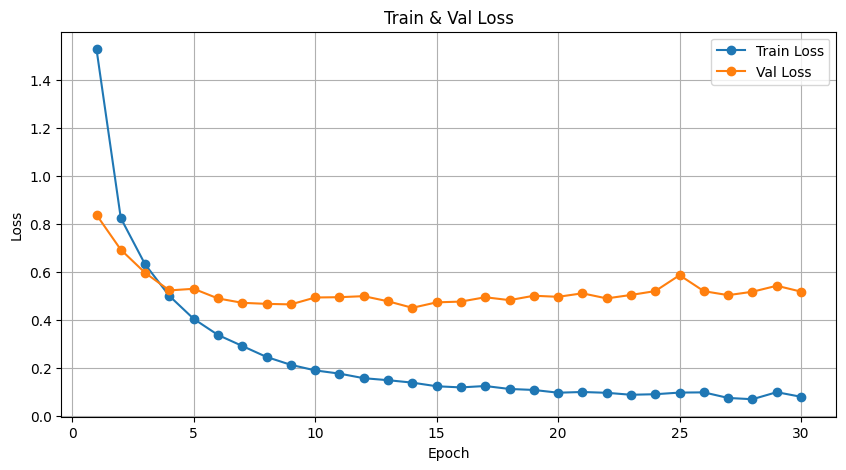

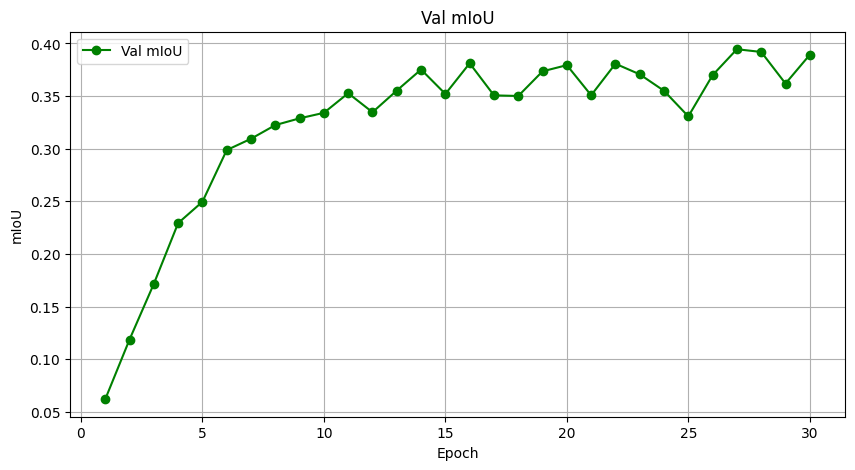

In [ ]:
# ============================================
# 3.3 Main Training Loop + Curves
# ============================================

num_epochs = 30
best_miou = 0.0
best_model_path = "best_deeplabv3_plantseg.pth"

train_losses = []
val_losses = []
val_mious = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
    val_loss, val_miou, _,val_macc, _  = evaluate(model, val_loader, criterion, NUM_CLASSES, split_name="val")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_mious.append(val_miou)


    if val_miou > best_miou:
        best_miou = val_miou
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✅ New best val mIoU: {best_miou:.4f}, model saved to {best_model_path}")


epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10,5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Val Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epochs, val_mious, label='Val mIoU', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Val mIoU')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ============================================
# 3.4 Final Test Evaluation
# ============================================

# load best model
print("Loading best model from:", best_model_path)
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))

test_loss, test_miou, test_iou_per_class, test_macc, test_acc_per_class = evaluate(
    model, test_loader, criterion, NUM_CLASSES, split_name="test"
)

print(f"Final Test Loss: {test_loss:.4f}, Test mIoU: {test_miou:.4f}, Test mAcc: {test_macc:.4f}")



Loading best model from: best_deeplabv3_plantseg.pth


[test] evaluating:   0%|          | 0/574 [00:00<?, ?it/s]

test loss = 0.5140, test mIoU = 0.4010, test mAcc = 0.5346
Final Test Loss: 0.5140, Test mIoU: 0.4010, Test mAcc: 0.5346


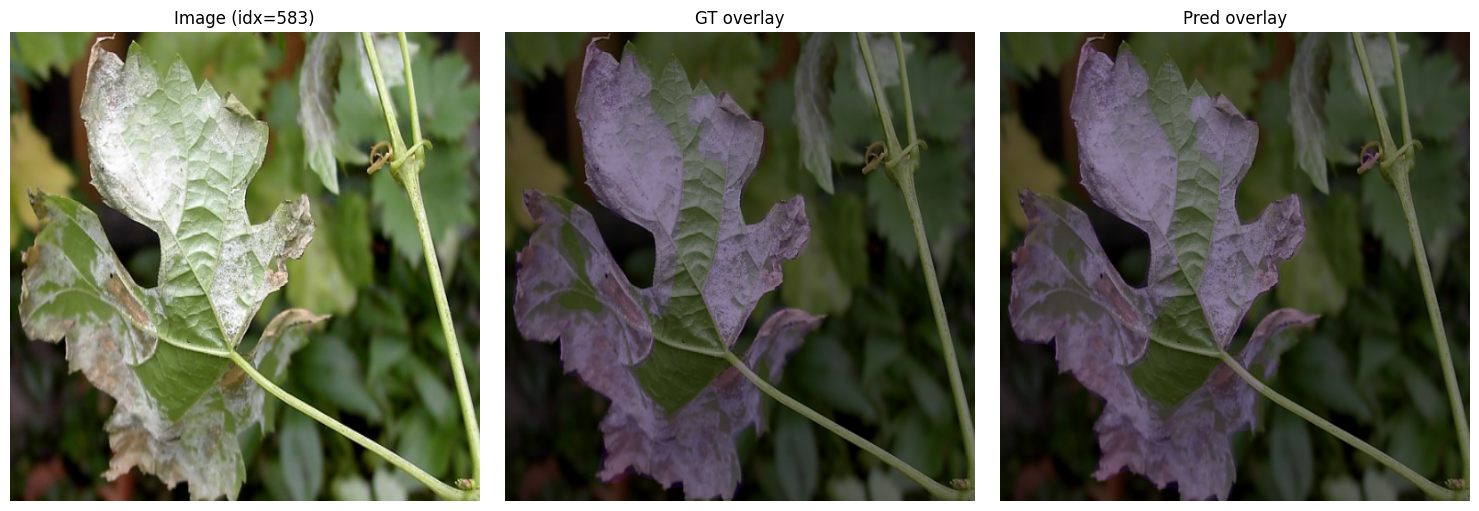

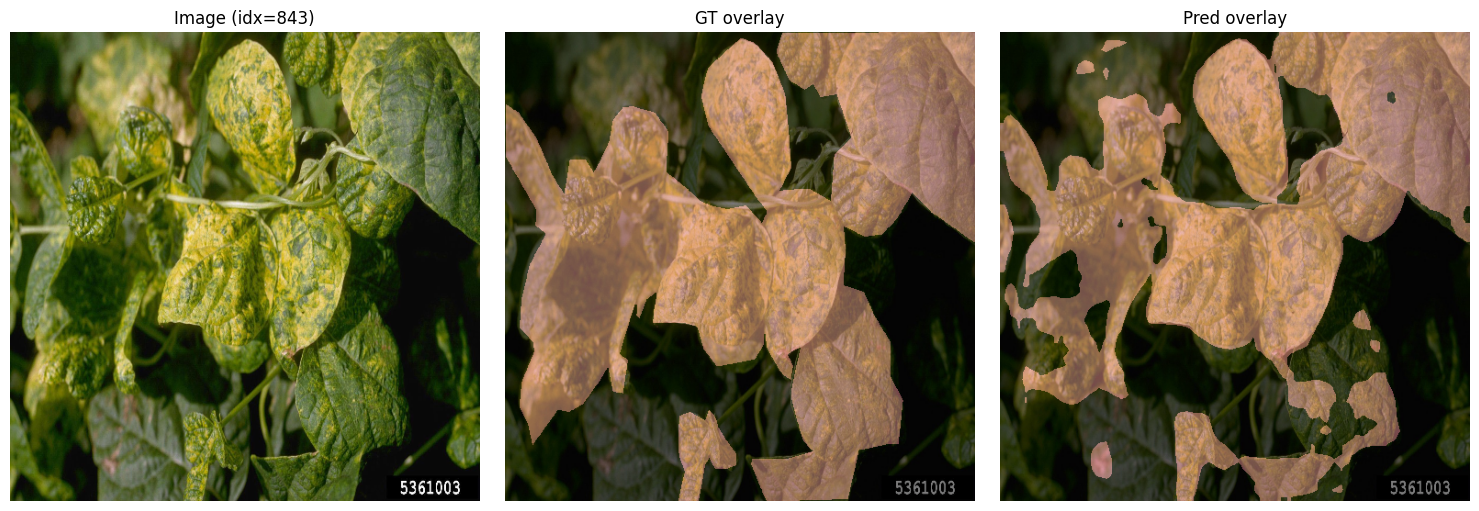

In [ ]:
# ============================================
# 3.5 Visualize Predictions with Color Overlay
# ============================================

np.random.seed(0)
CLASS_COLORS = np.random.randint(0, 255, size=(NUM_CLASSES, 3), dtype=np.uint8)
CLASS_COLORS[0] = (0, 0, 0)  


def mask_to_color(mask_np, class_colors):
    """
    mask_np: [H,W], int
    return: [H,W,3], uint8
    """
    h, w = mask_np.shape
    color_mask = class_colors[mask_np.reshape(-1)].reshape(h, w, 3)
    return color_mask


def visualize_predictions(model, dataset, num_samples=4):
    model.eval()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    indices = np.random.choice(len(dataset), size=min(num_samples, len(dataset)), replace=False)

    with torch.no_grad():
        for idx in indices:
            img, mask = dataset[idx]
            img_in = img.unsqueeze(0).to(DEVICE)
            mask_np = mask.numpy()

            out = model(img_in)["out"]
            pred = out.argmax(1).squeeze(0).cpu().numpy()

            # 反归一化
            img_vis = img.clone()
            img_vis = img_vis * std + mean
            img_vis = img_vis.clamp(0,1).permute(1,2,0).cpu().numpy()

            gt_color = mask_to_color(mask_np, CLASS_COLORS)
            pred_color = mask_to_color(pred, CLASS_COLORS)

            alpha = 0.5
            gt_overlay = (img_vis * 255 * (1-alpha) + gt_color * alpha).astype(np.uint8)
            pred_overlay = (img_vis * 255 * (1-alpha) + pred_color * alpha).astype(np.uint8)

            fig, axs = plt.subplots(1, 3, figsize=(15,5))
            axs[0].imshow(img_vis)
            axs[0].set_title(f"Image (idx={idx})")
            axs[0].axis("off")

            axs[1].imshow(gt_overlay)
            axs[1].set_title("GT overlay")
            axs[1].axis("off")

            axs[2].imshow(pred_overlay)
            axs[2].set_title("Pred overlay")
            axs[2].axis("off")

            plt.tight_layout()
            plt.show()


# examples
visualize_predictions(model, val_dataset, num_samples=1)
visualize_predictions(model, val_dataset, num_samples=1)


Save Model to Google Driver

In [17]:
model_path = f"{SAVE_DIR}/deeplabv3_resnet101_batch_8_lr_1e-4.pth"
torch.save(model.state_dict(), model_path)

print("Saved model to:", model_path)


Saved model to: /content/drive/MyDrive/DeepLearning/final_project/models/deeplabv3_resnet101_batch_8_lr_1e-4.pth
